In [17]:
import numpy as np
import torch
from src import kernel_flow, datagen
import tqdm
import matplotlib.pyplot as plt

# Van der Pol

## Regular time steps

In [17]:
# generate dataset
Data = datagen.VDP(T=25, dt=0.0025,sigma=1.5,rho=0,N_sims=1)[0]
#train test split
observed_data= Data
train_data = Data[:5000,:].T
test_data = Data[5000:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)
model,_ = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.96it/s]


In [18]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0215


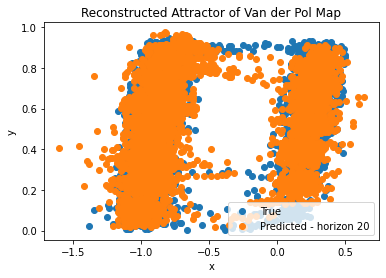

In [19]:
import matplotlib.pyplot as plt
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = f"Predicted - horizon {horizon}")
plt.title("Reconstructed Attractor of Van der Pol Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

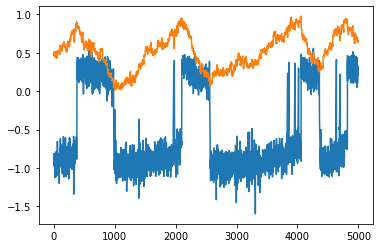

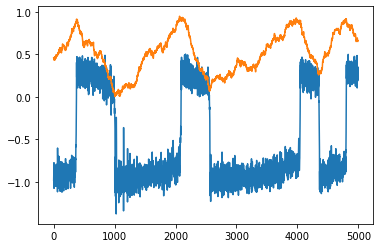

In [20]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])

### n steps interval

In [29]:
n = 3

# generate dataset
Data = datagen.VDP(T=25, dt=0.0025,sigma=1.5,rho=0,N_sims=1)[0]
#train test split
observed_data= Data[0::n]
train_data = Data[:5000,:].T
test_data = Data[5000:,:].T


# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)
model,_ = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.75it/s]


In [30]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 20

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0122


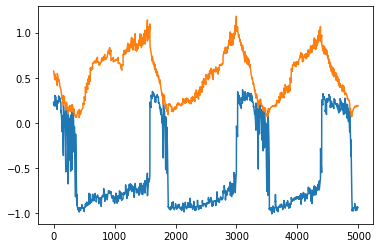

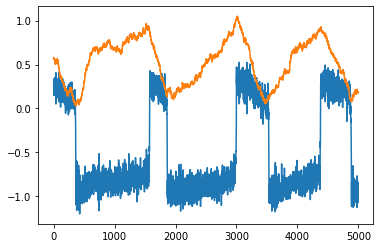

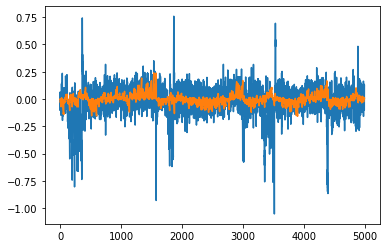

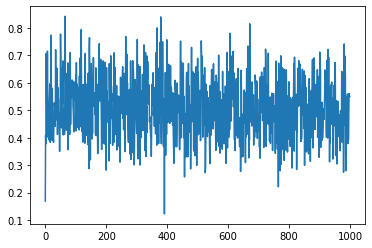

In [31]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()
plt.plot(rho_list)

# Irregular Sampling

## Classical Kernel Flow

In [25]:
max_delay = 5
N_points = 10000
train_n = 5000
burnin = 200
dt = 0.0025
sigma = 0

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx*dt)
# generate dataset
#Data = datagen.Henon(T=T+burnin*dt, dt=dt,N_sims=1,a=1.4,b=0.3)[0][burnin:]

# generate dataset
Data = datagen.VDP(T=T+burnin*dt, dt=0.0025,sigma=sigma,rho=0,N_sims=1)[0]

#times
observed_data = Data[indices]

train_data = observed_data[:train_n,:].T
test_data = observed_data[train_n:,:].T
delays_train = delays[:train_n]
delays_test = delays[train_n:]

In [48]:
# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model, rho_list  = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr, epochs = 1000)

0it [00:00, ?it/s]


In [51]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 0.2900 - R2 : 0.3261


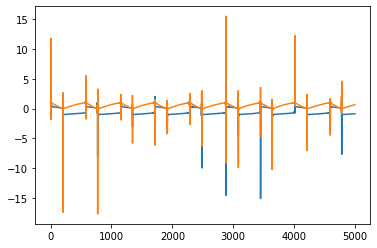

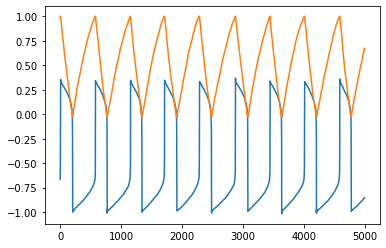

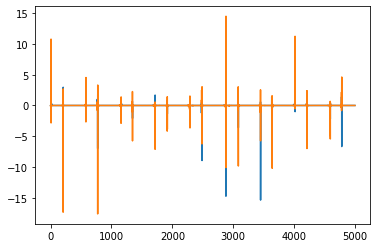

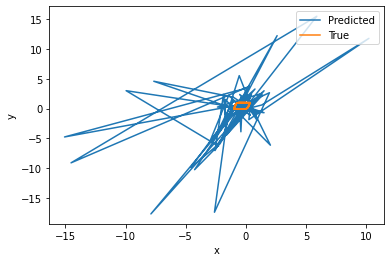

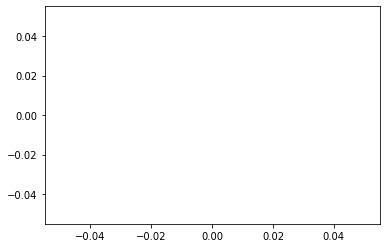

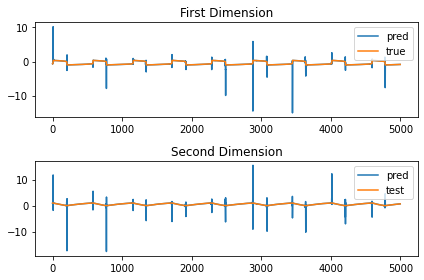

In [52]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()
plt.plot(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.plot(Y_test[:,0],Y_test[:,1], label = "True")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "upper right")
plt.figure()
plt.plot(rho_list)

fig, ax = plt.subplots(2,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")
fig.tight_layout()

## Irregular Kernel Flows

In [22]:
# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001
lr = 0.01

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize, delays_test)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model, rho_list  = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.87it/s]


In [23]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 10

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()
r2 = 1-mse_pred/Y_test.var()

print(f"MSE On test : {mse_pred:.4f} - R2 : {r2:.4f}")

MSE On test : 0.0000 - R2 : 1.0000


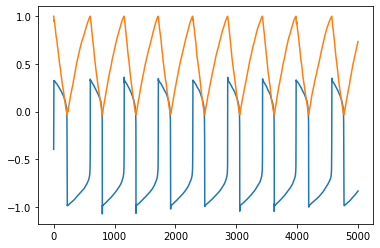

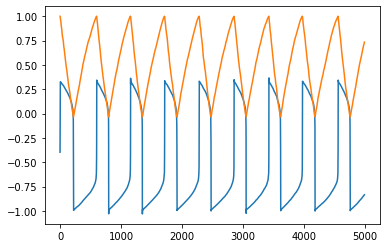

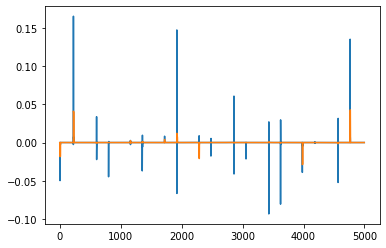

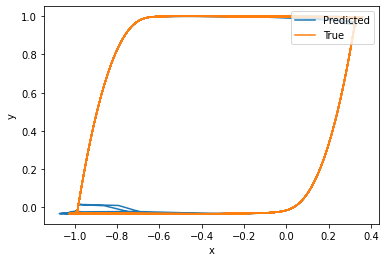

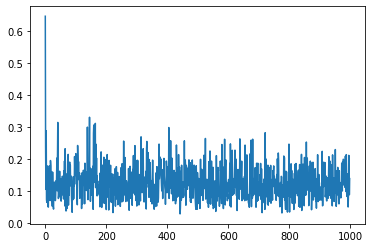

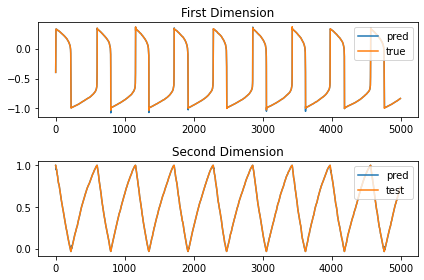

In [24]:
plt.plot(Y_pred[:,:].detach())
plt.figure()
plt.plot(Y_test[:,:])
plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.figure()
plt.plot(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.plot(Y_test[:,0],Y_test[:,1], label = "True")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "upper right")
plt.figure()
plt.plot(rho_list)

fig, ax = plt.subplots(2,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")
fig.tight_layout()